In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Network Analysis

## Basic measures

Read the network

In [3]:
def edges_to_graph(data):
    """ Functionn to convert edges to graph
    Parameters:
    - data: str, name of the data folder
    Returns:
    - G: nx.Graph, graph of the data
    """
    edges = pd.read_csv(f'{data}/edges.csv')
    # You need to make sure that the source and target columns are correctly named as follows
    G = nx.from_pandas_edgelist(edges, source='source', target='target')
    return G

In [4]:
G = edges_to_graph('facebook_L1')

### Density

In [5]:
# Function to calculate the density of a graph
def density(graph):
    """ Function to calculate the density of a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    Returns:
    - density: float
    """
    n = len(graph.nodes()) # number of nodes
    m = len(graph.edges()) # number of edges
    return 2*m/(n*(n-1))

### Average clustering coefficient

In [6]:
def average_clustering(graph):
    """ Function to calculate the average clustering coefficient of a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    Returns:
    - avg_clustering: float, average clustering coefficient of the graph
    """
    avg_clustering = 0
    n = len(graph.nodes())

    for i in graph.nodes():
        k_i = graph.degree(i)

        if k_i > 1: # Degree > 1 nodes have clustering
            t_i = 0
            neighbors = set(graph.neighbors(i))

            for j in neighbors:
                # Count shared neighbors between i and j, which form triangles with i
                common_neighbors = neighbors.intersection(graph.neighbors(j))
                t_i += len(common_neighbors)

            t_i /= 2  # Each triangle is counted twice
            avg_clustering += 2*t_i / (k_i * (k_i - 1))
            
        else:
            avg_clustering += 0  # Degree <= 1 nodes have clustering of 0

    avg_clustering /= n
    return avg_clustering

### Global clustering coefficient (Transitivity)

In [7]:
def C_3(graph):
    """ Function to calculate the number of triangles in a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    Returns:
    - C_3: int, number of triangles in the graph
    """
    C_3 = 0
    n = len(graph.nodes)

    for i in graph.nodes():
        k_i = graph.degree(i)

        if k_i >1: # Degree > 1 nodes have triangles
            t_i = 0
            neighbors = set(graph.neighbors(i))

            for j in neighbors:
                # Count shared neighbors between i and j, which form triangles with i
                common_neighbors = neighbors.intersection(set(graph.neighbors(j)))
                t_i += len(common_neighbors)

            t_i = t_i/2 # Each triangle is counted twice
            C_3 += t_i
            
    C_3 = C_3/3
    return C_3

def P_2(graph):
    """ Function to calculate the number of paths of length 2 in a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    Returns:
    - P_2: int, number of paths of length 2 in the graph
    """
    degrees = [val for (node, val) in graph.degree()]
    P_2 = 0
    P_2 = sum(k_i*(k_i-1) for k_i in degrees) # Calculate the number of paths of length 2
    P_2 = P_2/2
    return P_2

def transitivity(graph):
    """ Function to calculate the transitivity index of a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    Returns:
    - transitivity: float, transitivity index of the graph
    """
    transitivity = 3*C_3(graph)/P_2(graph)
    return transitivity

### Index bipartivity

In [8]:
adjacency_matrix = lambda G: nx.adjacency_matrix(G)

def bipartivity_index(G):
    
    """This function returns the biaprtivity index of a graph"""
    
    A = nx.adjacency_matrix(G).toarray()
    # Eigenvalues of the adjacency matrix
    eigenvalues = np.linalg.eigvals(A)
    
    exp_eig = np.exp(eigenvalues)
    exp_minus_eig = np.exp(-eigenvalues)
    
    trA = np.sum(exp_eig)
    tr_minus_A = np.sum(exp_minus_eig)
    
    # Bipartivity index
    bipartivity = tr_minus_A/trA
    
    return bipartivity

### Degree distribution

In [9]:
data_degree = lambda G: np.array([val for (node, val) in G.degree()])

In [10]:
def prob_degree(graph):
    """ Function to calculate the probability to find a node with degree k in a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    Returns:
    - prob_degree: probability to find a node with degree k
    - k: degree of the nodes
    """
    degrees = [val for (node, val) in graph.degree()] # List of degrees of all nodes in the graph
    n_k = np.zeros(max(degrees)+1) # Array to store the number of nodes with degree k

    for i in range(len(degrees)):
        n_k[degrees[i]] += 1 # Count the number of nodes with degree k

    k = np.arange(max(degrees)+1) 
    prob_degree = np.zeros(len(k)) 

    for i in range(len(k)):
        prob_degree[i] = n_k[i]/len(degrees) # Calculate the probability to find a node with degree k

    return prob_degree, k

def plot_degree_distribution(graph):
    """ Function to plot the degree distribution of a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    """
    p_k, degrees = prob_degree(graph)
    plt.bar(degrees, p_k)
    plt.xlabel(r'$k$')
    plt.ylabel(r'$p(k)$')
    plt.title(r'Degree distribution')
    plt.show() 
    return

def cummul_degree_distribution(p_k):
    """ Function to calculate the cumulative degree distribution of a graph
    
    Parameters:
    - p_k: array-like, probability to find a node with degree k
    
    Returns:
    - cumul_degree: array, cumulative degree distribution of the graph
    """
    return np.cumsum(p_k)


def loglog_degree_distribution(graph):
    """ Function to plot the log-log degree distribution of a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    """
    p_k, degrees = prob_degree(graph)
    plt.loglog(degrees, p_k, 'o', markersize=3)
    plt.xlabel(r'$k$', fontsize=14)
    plt.ylabel(r'$P_{\hat{k}}(k)$', fontsize=14)
    plt.title(r'PDF')
    plt.show()
    return

def plot_cummul_degree_distribution(p_k):
    """ Function to plot the cumulative degree distribution of a graph
    Parameters:
    - p_k: array, probability to find a node with degree k
    """
    cummul_p_k = cummul_degree_distribution(p_k)
    plt.plot(cummul_p_k)
    plt.xlabel(r'$k$', fontsize=14)
    plt.ylabel(r'$F_{\hat{k}}(k)$', fontsize=14)
    plt.title(r'CDF')
    plt.show()
    return

## Fittings distributions

In [11]:
from scipy.stats._continuous_distns import _distn_names
import scipy.stats

def best_fittings(graph):
    """Function to find the best fitting distribution for the degree distribution of a graph
    Parameters:
    - graph: <class 'networkx.classes.graph.Graph'>
    """

    p_k, degrees = prob_degree(graph)
    data = data_degree(graph)
    x = np.linspace(min(degrees), max(degrees), 10000)
    
    # Distributions
    distributions = [pdf for pdf in _distn_names if pdf not in ['levy_stable', 'studentized_range']]
    best_fit = dict()

    for i, distribution in enumerate(distributions):
        
        print(f'Fitting {distribution} distribution {i+1}/{len(distributions)}')
        distr = getattr(scipy.stats, distribution)
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = distr.fit(data)
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                pdf = distr.pdf(x, loc=0, scale=scale, *arg)
                cdf = distr.cdf(x, loc=0, scale=scale, *arg)
                k_stats, p_value = scipy.stats.kstest(p_k, distribution, args=params)
                best_fit[distribution] = (pdf, cdf, params, p_value)
        except Exception:
            pass

    sorted_best_fit = sorted(best_fit.items(), key=lambda x: x[1][3], reverse=True)

    return sorted_best_fit

In [12]:
# Not going to use this function
def plot_best_fittings(graph, N_top=5, model=None):

    """Function to plot the best fitting distribution for the degree distribution of a graph"""

    p_k, degrees = prob_degree(graph)
    best_fit = best_fittings(graph)

    print(best_fit)

    x_min = min(degrees)
    x_max = max(degrees)
    x = np.linspace(x_min, x_max, 10000)

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(degrees, p_k, '.', label="Data", markersize=8)
    ax[1].plot(degrees, cummul_degree_distribution(p_k), '.', label="Data", markersize=8)

    for i in range(N_top):

        pdf, cdf, params, p_value = best_fit[i][1]
        ax[0].plot(x, pdf, label=best_fit[i][0])
        ax[1].plot(x, cdf, label=best_fit[i][0])

        print(f"{best_fit[i][0]} distribution")
        print(f"Parameters: {params}")
        print(f"p-value: {p_value}")

    ax[0].set_xlabel(r"$k$", fontsize=14)
    ax[0].set_ylabel(r"$P_{\hat{k}}(k)$", fontsize=14)
    ax[0].legend()
    ax[0].set_title("PDF")
    
    if model != 'Erdos-Renyi':

        ax[0].set_xscale("log")
        ax[0].set_yscale("log")
        ax[0].set_ylim(1e-5, 1)
        ax[0].set_xlim(x_min-0.5, x_max+0.5)

        ax[1].set_yscale("log")


    ax[1].set_title("CDF")
    ax[1].set_xlabel(r"$k$", fontsize=14)
    ax[1].set_ylabel(r"$F_{\hat{k}}(k)$", fontsize=14)


    plt.tight_layout()
    plt.show()
    
    return

In [13]:
# Since KS test presents problems with the fitting of the distributions, we will use the AIC and BIC criteria to find the best fitting distribution

def calculate_aic_bic(data, dist, params):
    """
    Calculate AIC and BIC for a given distribution and its parameters.
    
    Parameters:
    - data: The dataset to fit.
    - dist: The distribution object (e.g., scipy.stats.lognorm).
    - params: Parameters of the fitted distribution.
    
    Returns:
    - AIC and BIC values.
    """
    n = len(data)  # Number of data points
    k = len(params)  # Number of parameters
    
    # Calculate log-likelihood
    log_likelihood = np.sum(dist.logpdf(data, *params))
    
    # Compute AIC and BIC
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(n) - 2 * log_likelihood
    
    return aic, bic

In [14]:
from scipy.stats import lognorm, expon, pareto, burr, fisk, kstest, fatiguelife, johnsonsu, genpareto, ks_1samp
import powerlaw
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

def fit_distributions(data, degrees, p_k, model=None):

    """ Function to fit distributions to the degree distribution of a graph."""

    x_min = np.min(data)
    x_max = np.max(data)
    x = np.linspace(x_min, x_max, 100000)
    

    # Define distributions to test

    if model == 'Erdos-Renyi':

        distributions = {
        "Log-normal": lognorm,
        "Burr": burr,
        "Fisk": fisk,
        "Birnbaum-Saunders": fatiguelife,
        "Johnson SU": johnsonsu,
    }
        
    else:

        distributions = {
        "Log-normal": lognorm,
        "Power law": powerlaw,
        "Burr": burr,
        "Fisk": fisk,
        "Birnbaum-Saunders": fatiguelife,
        "Johnson SU": johnsonsu,
        "Generalized Pareto": genpareto,
    }


    print("PARAMETERS:")

    # Fit distributions and calculate AIC/BIC
    fits = {}
    for name, dist in distributions.items(): 
        
        if name == "Power law":
            
            fit = powerlaw.Fit(data, xmin=x_min, xmax=x_max ,discrete=True)
            print('Power law: \n alpha =', fit.alpha, ' error =', fit.sigma, '\n xmin =', fit.xmin, '\n xmax =', fit.xmax)

            x_power_law = np.linspace(x_min, x_max, 1000)

            cdf = fit.power_law.cdf(x_power_law)
            ks_stat, p_value = kstest(data, lambda x: fit.power_law.cdf(x))

            params = (fit.alpha,)  # Power-law has one parameter (alpha)
            log_likelihood = fit.power_law.loglikelihood
            k = len(params)
            
            # AIC and BIC
            aic = 2 * k - 2 * log_likelihood
            bic = k * np.log(len(data)) - 2 * log_likelihood
            
            fits[name] = {
                "pdf": fit.power_law.pdf(x_power_law),
                "cdf": cdf,
                "p_value": p_value,
                "aic": aic,
                "bic": bic,
            }

            
        else:

            if model == 'Erdos-Renyi':
                params = dist.fit(data)
            else:
                params = dist.fit(data, floc=0)
                
            # print(name, params)
            ks_stat, p_value = ks_1samp(data, dist.cdf, args=params)
            aic, bic = calculate_aic_bic(data, dist, params)
            fits[name] = {
                "params": params,
                "pdf": dist.pdf(x, *params),
                "cdf": dist.cdf(x, *params),
                "p_value": p_value,
                "aic": aic,
                "bic": bic,
            }

    # Plot comparisons
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    if model != 'Erdos-Renyi':
        
        axins = ax[1].inset_axes([0.3, 0.1, 0.6, 0.5], xlim=(0, 100), ylim=(0.8, 1.01))
        axins.plot(degrees, cummul_degree_distribution(p_k), '.', label="Data", markersize=8)
    


    # ax[0].hist(data, bins=50, density=True, alpha=0.5, label="Data", range=(np.min(degrees), np.max(degrees)))
    ax[0].plot(degrees, p_k, '.', label="Data", markersize=8)
    # ax[0].loglog(data, p_k, '.', label="Data")
    ax[1].plot(degrees, cummul_degree_distribution(p_k), '.', label="Data", markersize=8)

    colors = ["r", "g", "b", "k", "m", "brown", "orange", "purple", "cyan"]


    i=0
    for name, fit in fits.items():

        # Plot if the p-value is lower than 0.05
        print(name, '\n p-value:', fit['p_value'], '\n AIC: ', fit['aic'], '\n BIC: ', fit['bic'])

        if fit["p_value"] >= 0:

            if name == "Power law":
                ax[0].plot(x_power_law,fit["pdf"], label=name, color=colors[i], lw=1)
                ax[1].plot(x_power_law,fit["cdf"], label=name, color=colors[i], lw=1)

                if model != 'Erdos-Renyi':
                    axins.plot(x_power_law,fit["cdf"], label=name, color=colors[i], lw=1)

            else:
                
                print('\n Parameters:', fit['params'])
                ax[0].plot(x,fit["pdf"], label=name, color=colors[i], lw=1)
                ax[1].plot(x,fit["cdf"], label=name, color=colors[i], lw=1)     

                if model != 'Erdos-Renyi':
                    axins.plot(x,fit["cdf"], label=name, color=colors[i], lw=1)   
                
            i+=1

    ax[0].set_xlabel(r"$k$", fontsize=14)
    ax[0].set_ylabel(r"$P_{\hat{k}}(k)$", fontsize=14)
    ax[0].legend()
    ax[0].set_title("PDF")
    
    if model != 'Erdos-Renyi':

        ax[0].set_xscale("log")
        ax[0].set_yscale("log")
        ax[0].set_ylim(1e-5, 1)
        ax[0].set_xlim(x_min-0.5, x_max+0.5)
        ax[1].indicate_inset_zoom(axins)
        ax[1].set_yscale("log")


    ax[1].set_title("CDF")
    ax[1].set_xlabel(r"$k$", fontsize=14)
    ax[1].set_ylabel(r"$F_{\hat{k}}(k)$", fontsize=14)


    plt.tight_layout()
    plt.show()

    return

The lower AIC and BIC are, the better is the approximation. Since none of them perfectly fits (low p-value) we need a balance between the empirical observation, KS test and BIC and AIC.

In [15]:
def basic_properties(G):
    
    """This function returns basic properties of a graph"""
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    aspl = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
    assortativity = nx.degree_assortativity_coefficient(G)
    bipartivity = bipartivity_index(G)
    
    return n, m, density, avg_clustering, transitivity, aspl, diameter, assortativity, bipartivity

In [16]:
def full_analysis(G):

    """ Function to perform a full analysis of a graph
    Parameters:
    - data: str, name of the data folder
    """

    # Values to compute
    n, m, density, avg_clustering, transitivity, aspl, diameter, assortativity, bipartivity = basic_properties(G)
    print(f"Number of nodes: {n}")
    print(f"Number of edges: {m}")
    print(f"Density: {density}")
    print(f"Average clustering coefficient: {avg_clustering}")
    print(f"Transitivity: {transitivity}")
    print(f"Average shortest path length: {aspl}")
    print(f"Diameter: {diameter}")
    print(f"Assortativity: {assortativity}")
    print(f"Bipartivity index: {bipartivity}")

    # Degree distribution
    pk, degrees = prob_degree(G)
    plot_degree_distribution(G)
    loglog_degree_distribution(G)
    plot_cummul_degree_distribution(pk)

    # Fit distributions
    fit_distributions(data_degree(G), degrees, pk)

    return


Number of nodes: 5793
Number of edges: 30753
Density: 0.0018330968124036153
Average clustering coefficient: 0.17068434742781205
Transitivity: 0.26458216686976854
Average shortest path length: 6.263403488492971
Diameter: 16
Assortativity: 0.043649747006472145
Bipartivity index: (1.8684962415962121e-16-5.0208254541460565e-56j)


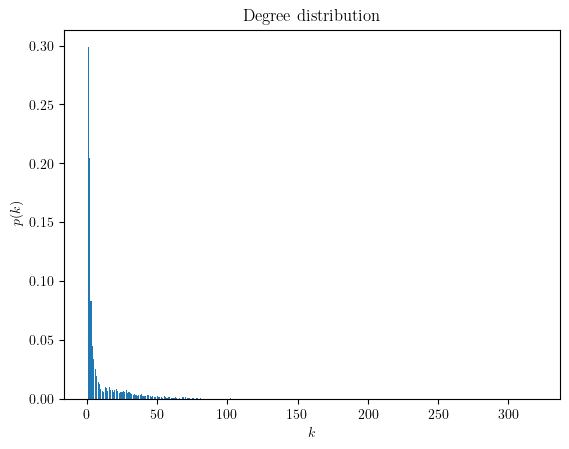

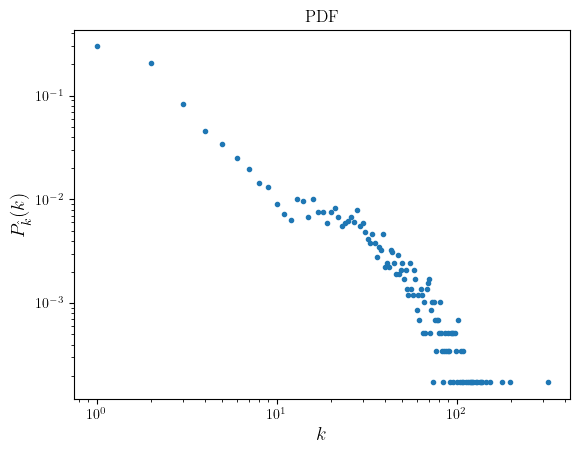

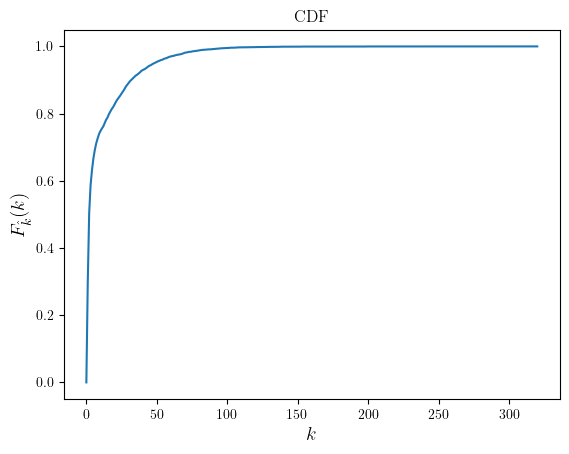

PARAMETERS:
Power law: 
 alpha = 1.4356403263708408  error = 0.005723692721834793 
 xmin = 1.0 
 xmax = 320.0
Log-normal 
 p-value: 7.072115494983368e-194 
 AIC:  35571.74729537175 
 BIC:  35591.74051208504

 Parameters: (np.float64(1.33480299628213), 0, np.float64(3.9039750729903364))
Power law 
 p-value: 0.0 
 AIC:  34239.54324371121 
 BIC:  34246.2076492823
Burr 
 p-value: 1.427021170513519e-167 
 AIC:  34369.003401300346 
 BIC:  34395.66102358473

 Parameters: (np.float64(1.0227159109291546), np.float64(376.4304858264543), 0, np.float64(0.00640890785246272))
Fisk 
 p-value: 1.0837107943815505e-154 
 AIC:  35860.39010412138 
 BIC:  35880.38332083467

 Parameters: (np.float64(1.2812020410206078), 0, np.float64(3.3639892094224884))
Birnbaum-Saunders 
 p-value: 3.832679491777641e-285 
 AIC:  35076.199841353904 
 BIC:  35096.19305806719

 Parameters: (np.float64(1.572463656042053), 0, np.float64(5.1329972550285765))
Johnson SU 
 p-value: 1.7156718054482995e-193 
 AIC:  35573.85160861617

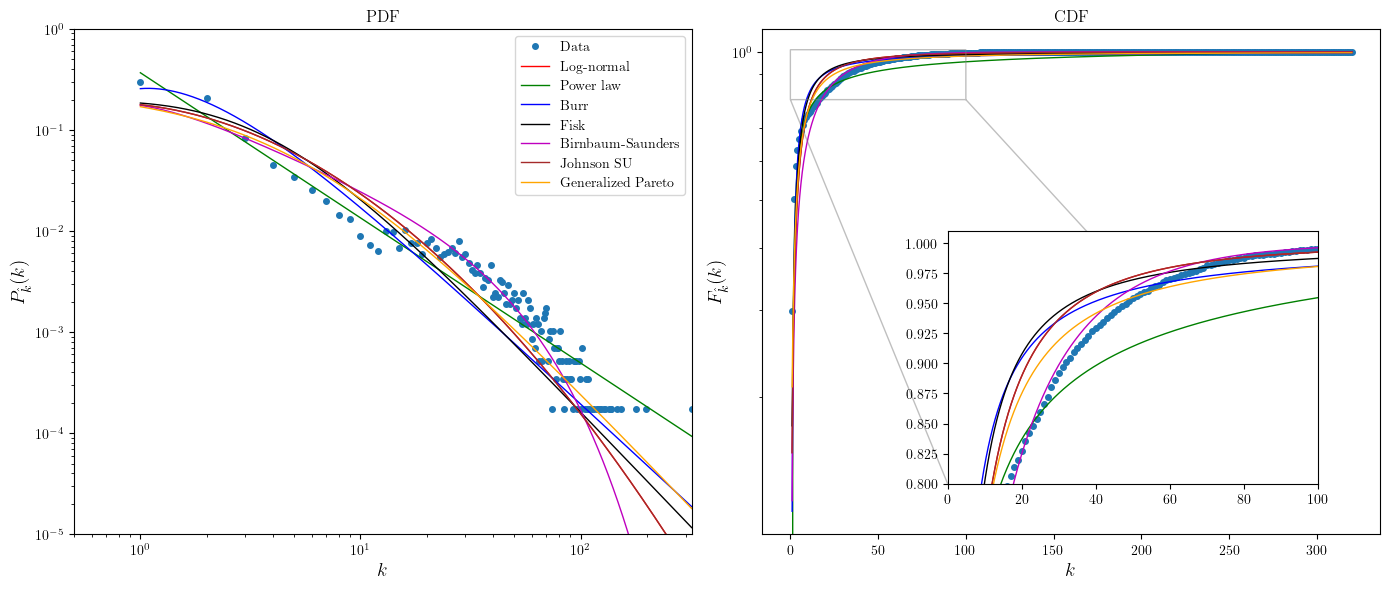

In [17]:
full_analysis(G)

In [18]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import approx_fprime

def compute_fisher_information(dist, data):
    """
    Compute the Fisher Information Matrix and standard errors of MLE parameters.
    
    Parameters:
        dist: scipy.stats distribution (e.g., stats.norm, stats.gamma)
        data: array-like, the observed data
    
    Returns:
        params_mle: Estimated parameters (MLE)
        fisher_info: Fisher Information Matrix
        cov_matrix: Covariance matrix (inverse of Fisher Info)
        std_errors: Standard errors of estimated parameters
    """

    # Step 1: Fit the distribution to get MLE parameters
    params_mle = dist.fit(data, floc=0)  # Fit the distribution
    num_params = len(params_mle)  # Number of parameters (e.g., 2 for normal: mean, std)

    # Step 2: Define negative log-likelihood function
    def neg_log_likelihood(params, data):
        return -np.sum(dist.logpdf(data, *params))  # Log-likelihood

    # Step 3: Compute the Hessian numerically
    epsilon = np.sqrt(np.finfo(float).eps)  # Small step for numerical differentiation

    def hessian(f, params, epsilon, data):
        """Compute numerical Hessian matrix."""
        n = len(params)
        hess = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                ei = np.zeros(n)
                ej = np.zeros(n)
                ei[i] = epsilon
                ej[j] = epsilon
                hess[i, j] = (f(params + ei + ej, data) - f(params + ei, data)
                              - f(params + ej, data) + f(params, data)) / (epsilon ** 2)
        return hess

    hess_matrix = hessian(neg_log_likelihood, np.array(params_mle), epsilon, data)
    
    # Step 4: Compute Fisher Information and standard errors
    fisher_info = -hess_matrix  # Fisher Information is negative Hessian
    cov_matrix = np.linalg.pinv(fisher_info)  # Use pseudo-inverse to handle singularity
    std_errors = np.sqrt(np.diag(cov_matrix))  # Standard errors

    return params_mle, fisher_info, cov_matrix, std_errors

In [19]:
# Example usage with a normal distribution
np.random.seed(42)
data = data_degree(G)

distributions = {
        "Log-normal": lognorm,
        "Burr": burr,
        "Fisk": fisk,
        "Birnbaum-Saunders": fatiguelife,
        "Johnson SU": johnsonsu,
        "Generalized Pareto": genpareto,
    }

for name, dist in distributions.items():

    # Compute Fisher Information and errors
    params_mle, fisher_info, cov_matrix, std_errors = compute_fisher_information(dist, data)

    # Print results
    print(f"\n{name} distribution")
    print(f"MLE parameters: {params_mle}")
    print(f"Fisher Information Matrix:\n{fisher_info}")
    print(f"Covariance Matrix:\n{cov_matrix}")
    print(f"Standard errors: {std_errors}")


C:\Users\mate1\AppData\Local\Temp\ipykernel_11584\4023043763.py:50: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(np.diag(cov_matrix))  # Standard errors



Log-normal distribution
MLE parameters: (np.float64(1.33480299628213), 0, np.float64(3.9039750729903364))
Fisher Information Matrix:
[[-16384.     -0.     -0.]
 [    -0.     -0.     -0.]
 [    -0.     -0.     -0.]]
Covariance Matrix:
[[-6.10351562e-05  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Standard errors: [nan  0.  0.]

Burr distribution
MLE parameters: (np.float64(1.0227159109291546), np.float64(376.4304858264543), 0, np.float64(0.00640890785246272))
Fisher Information Matrix:
[[-1.3107200e+05  1.6384000e+04  4.9152000e+04  5.0298880e+06]
 [ 1.6384000e+04 -3.2768000e+04 -1.6384000e+04 -0.0000000e+00]
 [ 4.9152000e+04 -1.6384000e+04 -0.0000000e+00 -7.0451200e+05]
 [ 5.0298880e+06 -0.0000000e+00 -7.0451200e+05 -1.4680064e+08]]
Covariance Matrix:
[[ 3.99804910e-05  4.90454309e-05 -5.81103708e-05  1.64874516e-06]
 [ 4.90454309e-05  5.12500748e-05 -1.14489875e-04  2.22991204e-06]
 [-5.8110370

## Node ranking

List the top 25 nodes according to degree, closeness, betweenness, eigenvector, Katz index, PageRank and subgraph centrality.

In [20]:
import seaborn as sns

def centrality_ranking(G, N=25):
    
    """Return the ranking of nodes according to their rentrality."""
    
    centrality_measures = {
        "Degree" : nx.degree_centrality,
        "Closeness" : nx.closeness_centrality,
        "Betweenness" : nx.betweenness_centrality,
        "Eigenvector" : nx.eigenvector_centrality,
        "Katz" : lambda G: nx.katz_centrality(G, alpha=0.01, beta=1.0),
        "PageRank" : nx.pagerank,
        "Subgraph" : nx.subgraph_centrality,
    }
    
    ranking = {}
    for name, measure in centrality_measures.items():
        
        measure_values = measure(G)
        sorted_values = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)[:N]
        ranking[name] = sorted_values
        
    data = {measure: [node[0] for node in values] for measure, values in ranking.items()}
    data['Rank'] = np.arange(1, N+1)

    # Reordering columns to have 'Rank' as the first column
    column_order = ['Rank'] + list(ranking.keys())
        
    # Convert to pandas DataFrame
    ranking = pd.DataFrame(data)[column_order]
    # Convert to latex
    print(ranking.to_latex(index=False))
    
    return ranking

def kendall_correlation_matrix(G):
    
    """Return the Kendall correlation matrix between the centrality measures."""
    
    centrality_measures = {
        "DC" : nx.degree_centrality,
        "CC" : nx.closeness_centrality,
        "BC" : nx.betweenness_centrality,
        "EC" : nx.eigenvector_centrality,
        "K" : lambda G: nx.katz_centrality(G, alpha=0.01, beta=1.0),
        "PR" : nx.pagerank,
        "SC" : nx.subgraph_centrality,
    }
    
    measures = {name: measure(G) for name, measure in centrality_measures.items()}
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(measures)
    
    # Compute the Kendall correlation matrix
    corr = df.corr(method='kendall')
    
    # Convert to latex
    print(corr.to_latex())
    
    return corr

def plot_centrality_correlation(G):
    
    """Plot the correlation matrix between the centrality measures."""
    
    corr = kendall_correlation_matrix(G)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Kendall correlation matrix between centrality measures', fontsize=16)
    # Plot the correlation matrix with values
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
    plt.tight_layout()
    plt.show()
    
    return

def node_ranking_matrix_repetition(G, N=25):

    """Return a plotting matrix with the number of coincident nodes in the top N of the rankings."""

    centrality_measures = {
        "DC" : nx.degree_centrality,
        "CC" : nx.closeness_centrality,
        "BC" : nx.betweenness_centrality,
        "EC" : nx.eigenvector_centrality,
        "K" : lambda G: nx.katz_centrality(G, alpha=0.01, beta=1.0),
        "PR" : nx.pagerank,
        "SC" : nx.subgraph_centrality,
    }

    # Compute the rankings
    ranking = {}
    for name, measure in centrality_measures.items():
        measure_values = measure(G)
        sorted_values = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)[:N]
        ranking[name] = sorted_values

    # Create the matrix with the number of coincident nodes in the top N of the rankings
    matrix = np.zeros((len(ranking), len(ranking)))
    for i, (name1, values1) in enumerate(ranking.items()):
        for j, (name2, values2) in enumerate(ranking.items()):
            matrix[i, j] = len(set([node1[0] for node1 in values1]).intersection([node2[0] for node2 in values2]))

    matrix = matrix.astype(int)

    # Convert to pandas DataFrame
    df = pd.DataFrame(matrix, columns=ranking.keys(), index=ranking.keys())

    xticklabels = list(ranking.keys())
    yticklabels = list(ranking.keys())

    # Plot the matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Coincident nodes in the top 25 rankings', fontsize=16)
    sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=0.5, fmt="d")
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    plt.tight_layout()
    plt.show()

    return matrix



In [21]:
ranking = centrality_ranking(G)

\begin{tabular}{rrrrrrrr}
\toprule
Rank & Degree & Closeness & Betweenness & Eigenvector & Katz & PageRank & Subgraph \\
\midrule
1 & 184 & 2957 & 1485 & 184 & 184 & 3538 & 184 \\
2 & 988 & 1485 & 2957 & 712 & 524 & 1444 & 712 \\
3 & 524 & 17 & 1925 & 1099 & 1099 & 3402 & 1099 \\
4 & 143 & 988 & 183 & 219 & 712 & 3728 & 219 \\
5 & 2957 & 143 & 410 & 185 & 219 & 1699 & 185 \\
6 & 1099 & 74 & 3702 & 160 & 185 & 1661 & 160 \\
7 & 712 & 1862 & 1315 & 524 & 209 & 3276 & 524 \\
8 & 1134 & 2487 & 184 & 1102 & 488 & 1485 & 1102 \\
9 & 1444 & 1156 & 74 & 779 & 160 & 1412 & 779 \\
10 & 219 & 3975 & 143 & 488 & 779 & 988 & 488 \\
11 & 552 & 1407 & 1444 & 692 & 1134 & 2957 & 692 \\
12 & 3538 & 2967 & 17 & 480 & 1102 & 1411 & 480 \\
13 & 209 & 2208 & 1156 & 275 & 275 & 143 & 275 \\
14 & 185 & 2741 & 3277 & 240 & 692 & 1934 & 240 \\
15 & 488 & 2960 & 988 & 170 & 988 & 410 & 170 \\
16 & 537 & 3363 & 1412 & 209 & 240 & 3277 & 209 \\
17 & 160 & 4 & 3563 & 697 & 480 & 3303 & 697 \\
18 & 779 & 3829 & 221

\begin{tabular}{lrrrrrrr}
\toprule
 & DC & CC & BC & EC & K & PR & SC \\
\midrule
DC & 1.000000 & 0.163084 & 0.585996 & 0.643590 & 0.889278 & 0.637567 & 0.646283 \\
CC & 0.163084 & 1.000000 & 0.261524 & 0.409014 & 0.219475 & 0.069167 & 0.409355 \\
BC & 0.585996 & 0.261524 & 1.000000 & 0.340722 & 0.516034 & 0.647850 & 0.341389 \\
EC & 0.643590 & 0.409014 & 0.340722 & 1.000000 & 0.671429 & 0.264585 & 0.978656 \\
K & 0.889278 & 0.219475 & 0.516034 & 0.671429 & 1.000000 & 0.524999 & 0.675466 \\
PR & 0.637567 & 0.069167 & 0.647850 & 0.264585 & 0.524999 & 1.000000 & 0.264906 \\
SC & 0.646283 & 0.409355 & 0.341389 & 0.978656 & 0.675466 & 0.264906 & 1.000000 \\
\bottomrule
\end{tabular}



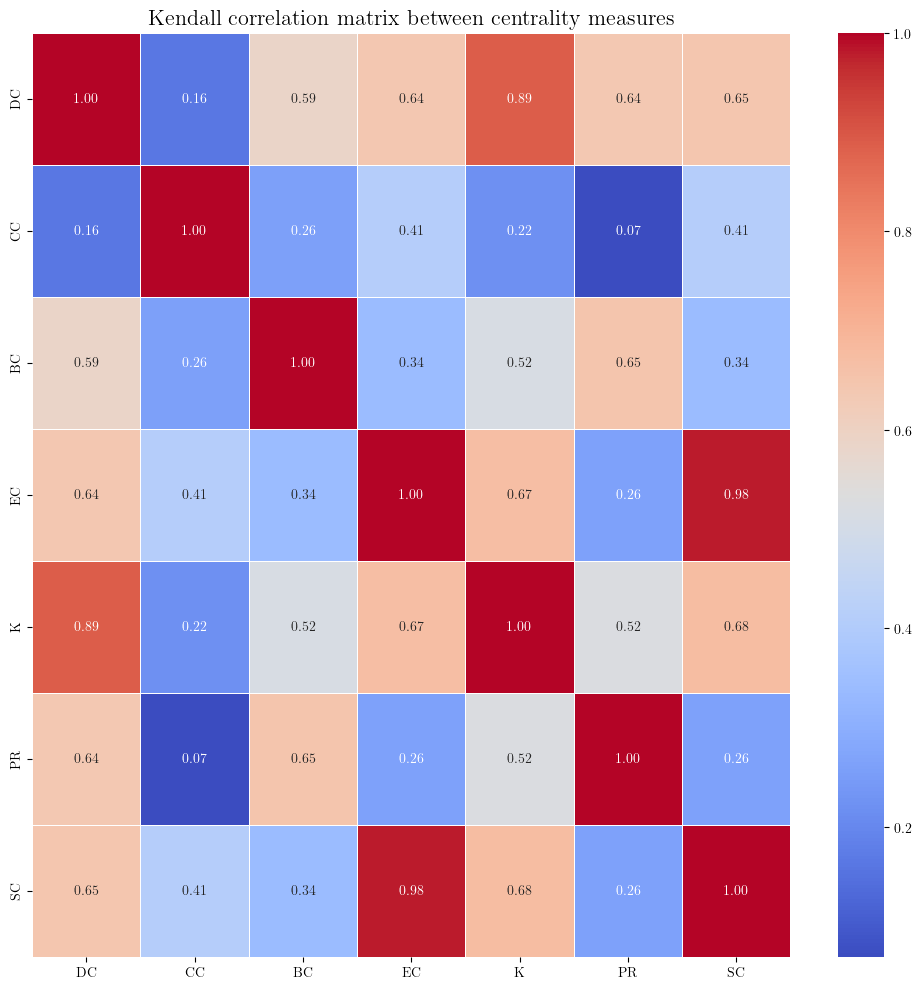

In [22]:
plot_centrality_correlation(G)

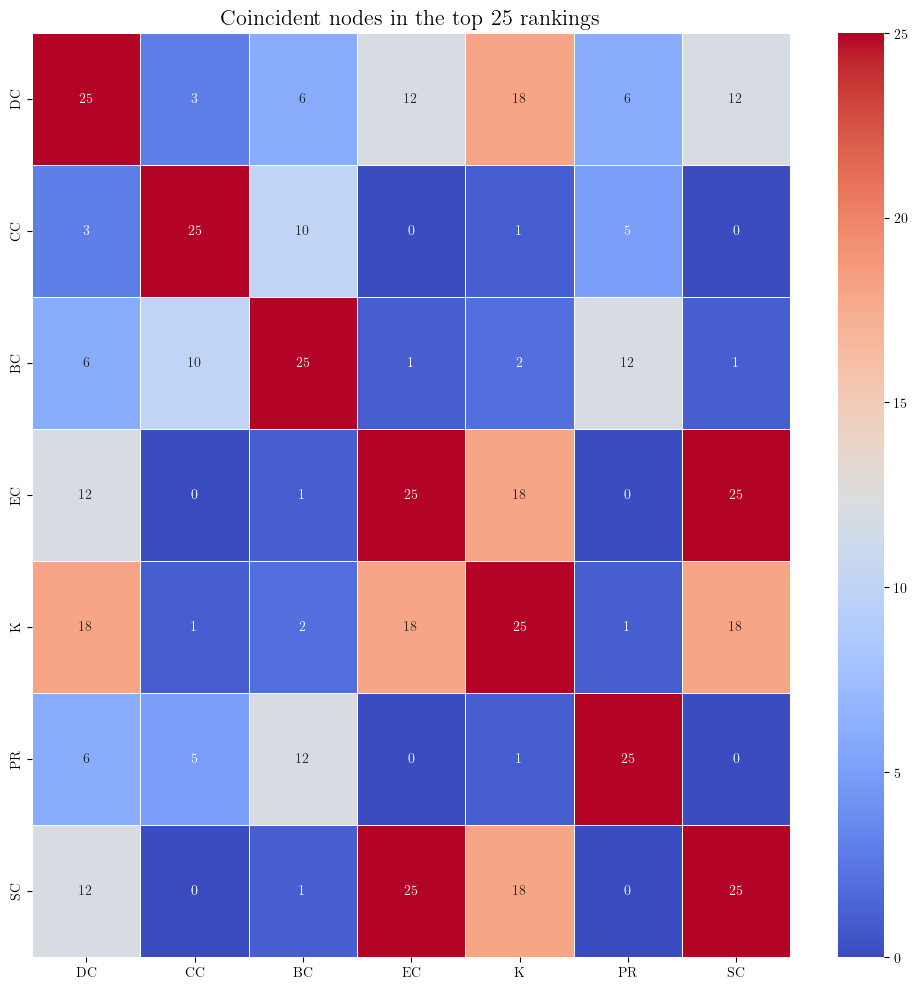

In [23]:
matrix = node_ranking_matrix_repetition(G)

## Erdös-Renyi

Generate 10 random realisations of the Erdös-Rényi with the same number of nodes and edges of the network.

### Network measures

In [24]:
def model_avg(G, model, N=10):
    """Function to calculate the average of the graph properties for a given model"""
    
    params = {
        "nodes": [],
        "edges": [],
        "density": [],
        "avg_clustering": [],
        "Transitivity": [],
        "Avg_shortest_path_length": [],
        "Diameter": [],
        "Degree_assortativity": [],
        "Bipartivity_index": [],
    }
    
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()

    p = 2 * edges / (nodes * (nodes - 1)) # Probability of connection from the expected number of edges
    m_initial = edges // nodes # Initial number of edges, ensuring that the graph is connected
    s=1
    while (s*(s-1))/2 <= edges - (nodes - s)*m_initial:
        s+=1
    initial_graph = nx.complete_graph(s)

    j=0
    
    while j < N:
         
        print("Iteration ", j+1)

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if model == "Erdos-Renyi":
                    G_model = nx.erdos_renyi_graph(nodes, p)
                elif model == "Barabasi-Albert":
                    G_model = nx.barabasi_albert_graph(nodes, m_initial, initial_graph=initial_graph)
                    
                values = basic_properties(G_model)
                
                for i, key in enumerate(params.keys()):
                    params[key].append(values[i])
                    
                j += 1
        except Exception as e:
            print(f"Error in iteration {j+1}: {e}")
            continue
    
    avg_params = {key: np.mean(values) for key, values in params.items()}
    std_params = {key: np.std(values)/np.sqrt(N) for key, values in params.items()}
    
    return avg_params, std_params        
        

In [25]:
avg_params, std_params = model_avg(G, "Erdos-Renyi", N=10)
# Convert to pandas DataFrame
index = ['Average', 'Standard deviation']
df = pd.DataFrame([avg_params, std_params], index=index)
df

Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Error in iteration 6: Graph is not connected.
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10


,nodes,edges,density,avg_clustering,Transitivity,Avg_shortest_path_length,Diameter,Degree_assortativity,Bipartivity_index
Average,5793.0,30851.500000,0.001839,0.001827,0.001853,3.914707,6.200000,-0.002226,0.608745
Standard deviation,0.0,42.886187,0.000003,0.000050,0.000047,0.002249,0.126491,0.001230,0.003463


In [26]:
# Print the results in latex
print(df.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
 & nodes & edges & density & avg_clustering & Transitivity & Avg_shortest_path_length & Diameter & Degree_assortativity & Bipartivity_index \\
\midrule
Average & 5793.000000 & 30851.500000 & 0.001839 & 0.001827 & 0.001853 & 3.914707 & 6.200000 & -0.002226 & 0.608745 \\
Standard deviation & 0.000000 & 42.886187 & 0.000003 & 0.000050 & 0.000047 & 0.002249 & 0.126491 & 0.001230 & 0.003463 \\
\bottomrule
\end{tabular}



### Plotting

In [27]:
def average_pdf(p_k):
    
    """Function to calculate the average probability density function"""

    len_x = [len(x) for x in p_k]
    k_max = int(np.max(len_x)) # Maximum length of the arrays
    avg_pdf = np.zeros(k_max)
    std_pdf = np.zeros(k_max)

    for i in range(k_max):
        value = [x[i] for x in p_k if i < len(x)]
        avg_pdf[i] = np.mean(value)
        std_pdf[i] = np.std(value)

    return avg_pdf, std_pdf

In [28]:
def average_pdf_model(G, model, N=10):

    """This function computes the average pdf and the cumulative pdf of a model"""
    
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()

    p = 2 * edges / (nodes * (nodes - 1)) # Probability of connection from the expected number of edges
    m_initial = edges // nodes # Initial number of edges, ensuring that the graph is connected
    
    p_k = []
    cummul_p_k = []
    
    for _ in range(N):
        
        if model == "Erdos-Renyi":
            G_model = nx.erdos_renyi_graph(nodes, p)
        elif model == "Barabasi-Albert":
            G_model = nx.barabasi_albert_graph(nodes, m_initial)
            
        p_k_model, _ = prob_degree(G_model)
        p_k.append(p_k_model)
        cdf_model = cummul_degree_distribution(p_k_model)
        cummul_p_k.append(cdf_model)

    avg_pdf, std_pdf = average_pdf(p_k)
    avg_cdf, std_cdf = average_pdf(cummul_p_k)


    return avg_pdf, std_pdf, avg_cdf, std_cdf

In [29]:
from scipy.stats import poisson

def plot_average_pdf_model(G, model, N=10):

    """Function to plot the average pdf and cdf of a model with their standard deviation"""

    avg_pdf, std_pdf, avg_cdf, std_cdf = average_pdf_model(G, model, N)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    if model == "Erdos-Renyi":
        fig.suptitle("Erdös-Rényi model", fontsize=16)
        color ='red'
        # Poisson distribution
        x = np.arange(0, len(avg_pdf))
        poisson_pmf = poisson.pmf(x, np.mean(data_degree(G)))
        ax[0].plot(x, poisson_pmf, label="Poisson distribution", color='blue', linestyle='dashed', zorder=1)
        print(f"Poisson distribution: lambda = {np.mean(data_degree(G))}")
        ax[1].plot(x, poisson.cdf(x, np.mean(data_degree(G))), label="Poisson distribution", color='blue', linestyle='dashed')
        

    elif model == "Barabasi-Albert":
        fig.suptitle("Barabási-Albert model", fontsize=16)
        color = 'k'

    ax[0].plot(avg_pdf, label="Average PDF", color = color)
    ax[0].fill_between(np.arange(len(avg_pdf)), avg_pdf-std_pdf, avg_pdf+std_pdf, alpha=0.3, label="Standard deviation", color = color)
    ax[0].set_xlabel(r"$k$", fontsize=14)
    ax[0].set_ylabel(r"$P_{\hat{k}}(k)$", fontsize=14)
    ax[0].legend()
    ax[0].set_title("PDF")

    if model == "Barabasi-Albert":
        ax[0].set_xscale("log")
        ax[0].set_yscale("log")
        ax[0].set_ylim(1e-6, 1)


    ax[1].plot(avg_cdf, label="Average CDF", color = color)
    ax[1].fill_between(np.arange(len(avg_cdf)), avg_cdf-std_cdf, avg_cdf+std_cdf, alpha=0.3, label="Standard deviation", color=color)
    ax[1].set_title("CDF")
    ax[1].set_xlabel(r"$k$", fontsize=14)
    ax[1].set_ylabel(r"$F_{\hat{k}}(k)$", fontsize=14)
    # ax[1].set_ylim(0.9, 1)
    # ax[1].set_xlim(0, 50)
    # ax[1].legend()

    plt.tight_layout()
    plt.show()

    return

Poisson distribution: lambda = 10.61729673744174


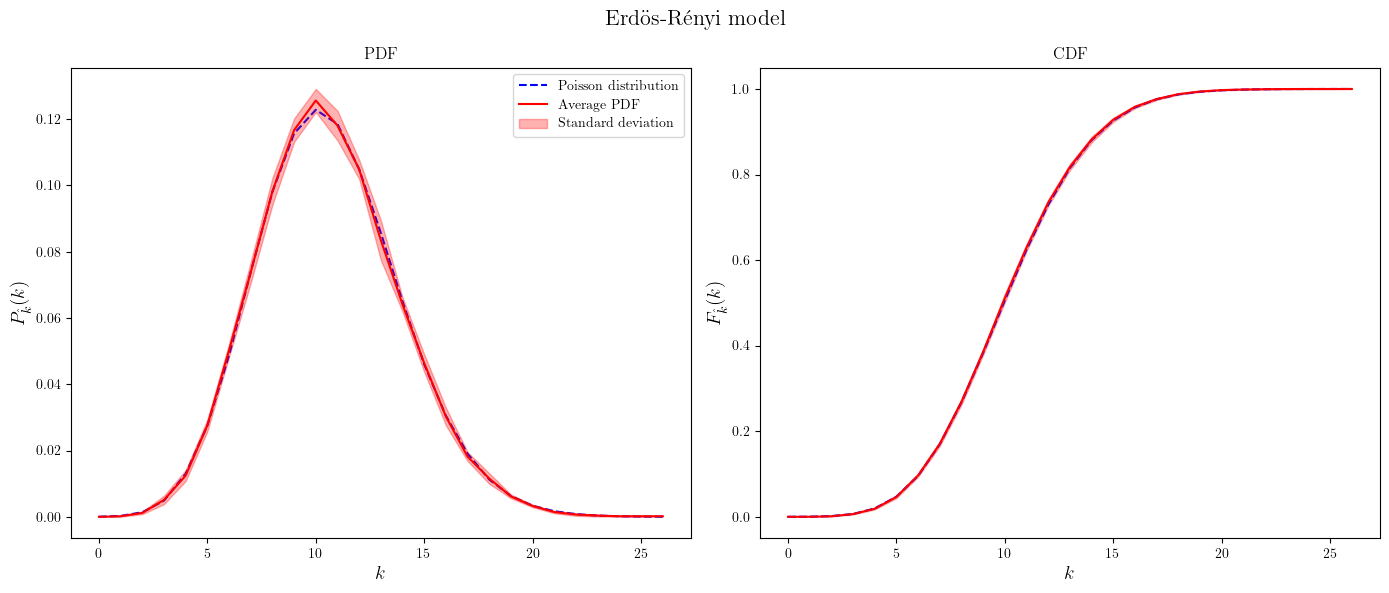

In [30]:
plot_average_pdf_model(G, "Erdos-Renyi", N=10)

### Fitting

In [31]:
def fitting_model(G, model, N=10):

    """This function fits the degree distribution of a model"""

    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    
    p_k = []
    cummul_p_k = []
    data_degrees = []
    m_initial = edges // nodes # Initial number of edges, ensuring that the graph is connected

    
    for _ in range(N):
        
        if model == "Erdos-Renyi":
            G_model = nx.gnm_random_graph(nodes, edges)
        elif model == "Barabasi-Albert":
            G_model = nx.barabasi_albert_graph(nodes, m_initial)
            
        p_k_model, degrees = prob_degree(G_model)
        p_k.append(p_k_model)
        cummul_p_k.append(cummul_degree_distribution(p_k_model))
        data_degrees.append(data_degree(G_model))

    data_flatted = [item for sublist in data_degrees for item in sublist]

    avg_pdf, std_pdf = average_pdf(p_k)
    avg_cdf, std_cdf = average_pdf(cummul_p_k)

    k = np.arange(len(avg_pdf))

    fit_distributions(data_flatted, k, avg_pdf, model=model)

    return

PARAMETERS:


c:\Users\mate1\OneDrive\Escritorio\Repository\Structural-Network-Analysis-of-Facebook-Friendship-in-a-Corporation\.venv\lib\site-packages\scipy\stats\_continuous_distns.py:6626: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


Log-normal 
 p-value: 2.9864426186084825e-197 
 AIC:  299993.60072182777 
 BIC:  300020.50169382006

 Parameters: (np.float64(0.10195973678693418), np.float64(-21.15709645951035), np.float64(31.60968856388857))
Burr 
 p-value: 2.8644994366450584e-295 
 AIC:  301012.8106393332 
 BIC:  301048.6786019896

 Parameters: (np.float64(7.863260667141688), np.float64(0.5066069774404975), np.float64(-0.5969496275471113), np.float64(12.74892953284797))
Fisk 
 p-value: 3.4696190444399033e-271 
 AIC:  301284.6328774342 
 BIC:  301311.5338494265

 Parameters: (np.float64(15.260343780215148), np.float64(-17.75861792484157), np.float64(28.202782041756848))
Birnbaum-Saunders 
 p-value: 4.324053034043913e-197 
 AIC:  299989.70947396255 
 BIC:  300016.61044595484

 Parameters: (np.float64(0.10238575608208046), np.float64(-21.066107041106214), np.float64(31.518202903590918))
Johnson SU 
 p-value: 3.4833725049238674e-198 
 AIC:  299998.3257055094 
 BIC:  300034.19366816577

 Parameters: (np.float64(-15.0432

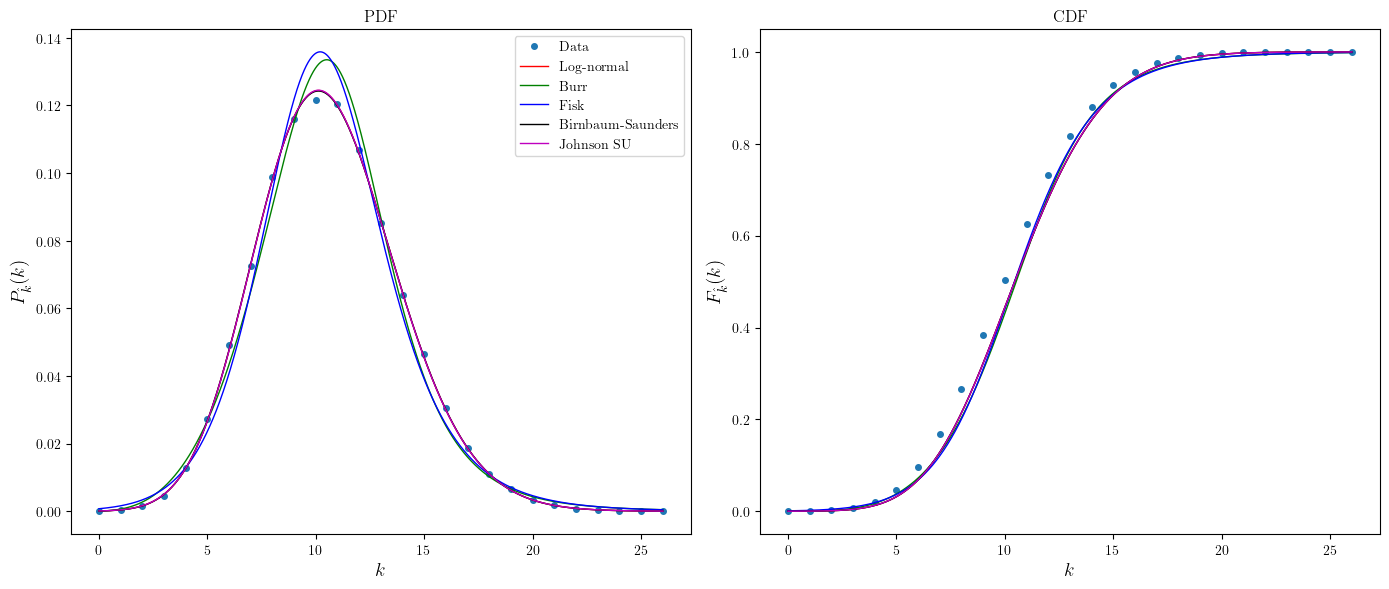

In [32]:
fitting_model(G, "Erdos-Renyi", N=10)

## Barabasi-Albert

Generate 10 random realisations of the Barabasi-Albert with the same number of nodes and edges of the network.

### Network measures

In [ ]:
avg_params, std_params = model_avg(G, "Barabasi-Albert", N=10)
# Convert to pandas DataFrame
index = ['Average', 'Standard deviation']
df = pd.DataFrame([avg_params, std_params], index=index)
df

Iteration  1


,nodes,edges,density,avg_clustering,Transitivity,Avg_shortest_path_length,Diameter,Degree_assortativity,Bipartivity_index
Average,5793.0,30780.0,0.001835,0.090695,0.080069,3.019466,5.0,-0.007399,3.397071e-24
Standard deviation,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00


In [34]:
print(df.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
 & nodes & edges & density & avg_clustering & Transitivity & Avg_shortest_path_length & Diameter & Degree_assortativity & Bipartivity_index \\
\midrule
Average & 5793.000000 & 30780.000000 & 0.001835 & 0.090695 & 0.080069 & 3.019466 & 5.000000 & -0.007399 & 0.000000 \\
Standard deviation & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}



### Plotting

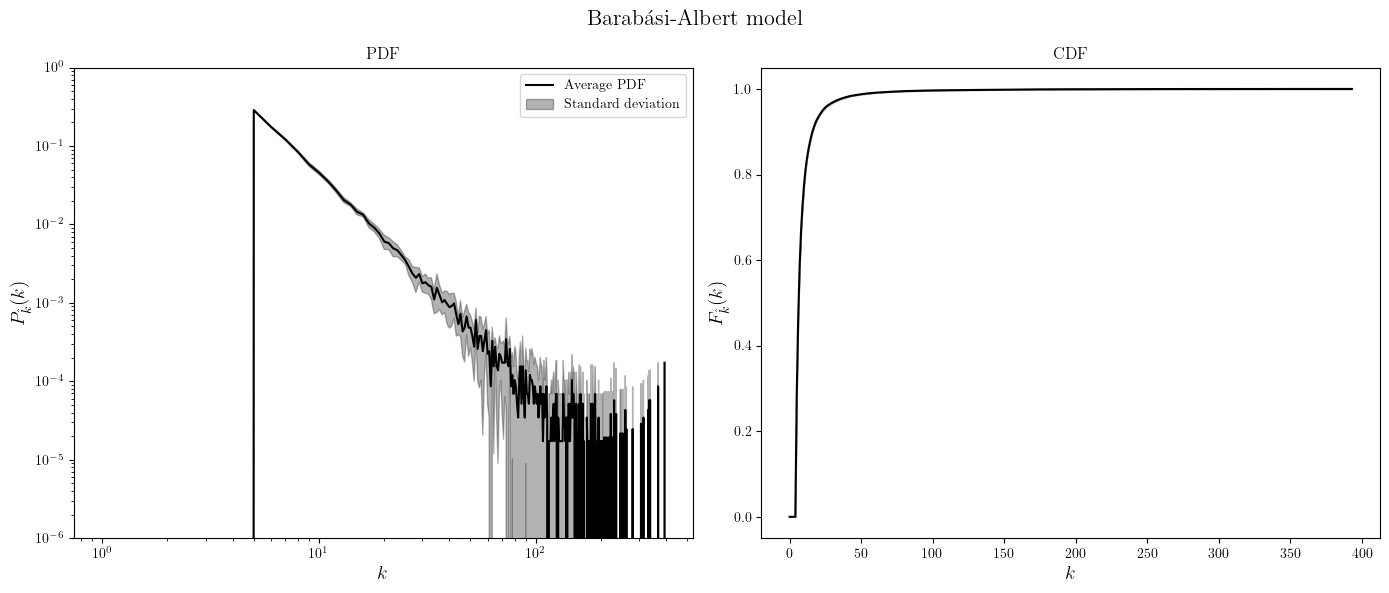

In [35]:
plot_average_pdf_model(G, "Barabasi-Albert", N=10)

### Fitting

PARAMETERS:
Power law: 
 alpha = 2.7589134220962346  error = 0.007307901730046551 
 xmin = 5.0 
 xmax = 452.0
Log-normal 
 p-value: 0.0 
 AIC:  334986.7129855579 
 BIC:  335013.6139575502

 Parameters: (np.float64(0.5444778080471153), 0, np.float64(8.006420422838437))
Power law 
 p-value: 0.0 
 AIC:  291839.8138244171 
 BIC:  291848.7808150812
Burr 
 p-value: 0.0 
 AIC:  307867.6614882208 
 BIC:  307903.52945087716

 Parameters: (np.float64(2.9442226816744617), np.float64(756.4730822445426), 0, np.float64(0.6737431909645157))
Fisk 
 p-value: 0.0 
 AIC:  326827.3432142064 
 BIC:  326854.2441861987

 Parameters: (np.float64(3.608619351854111), 0, np.float64(7.370774291053106))
Birnbaum-Saunders 
 p-value: 0.0 
 AIC:  342495.2019871793 
 BIC:  342522.1029591716

 Parameters: (np.float64(0.6017019451616084), 0, np.float64(8.508568954488716))
Johnson SU 
 p-value: 0.0 
 AIC:  334995.35855964187 
 BIC:  335031.22652229824

 Parameters: (np.float64(-9.342040369366682), np.float64(1.8347613216

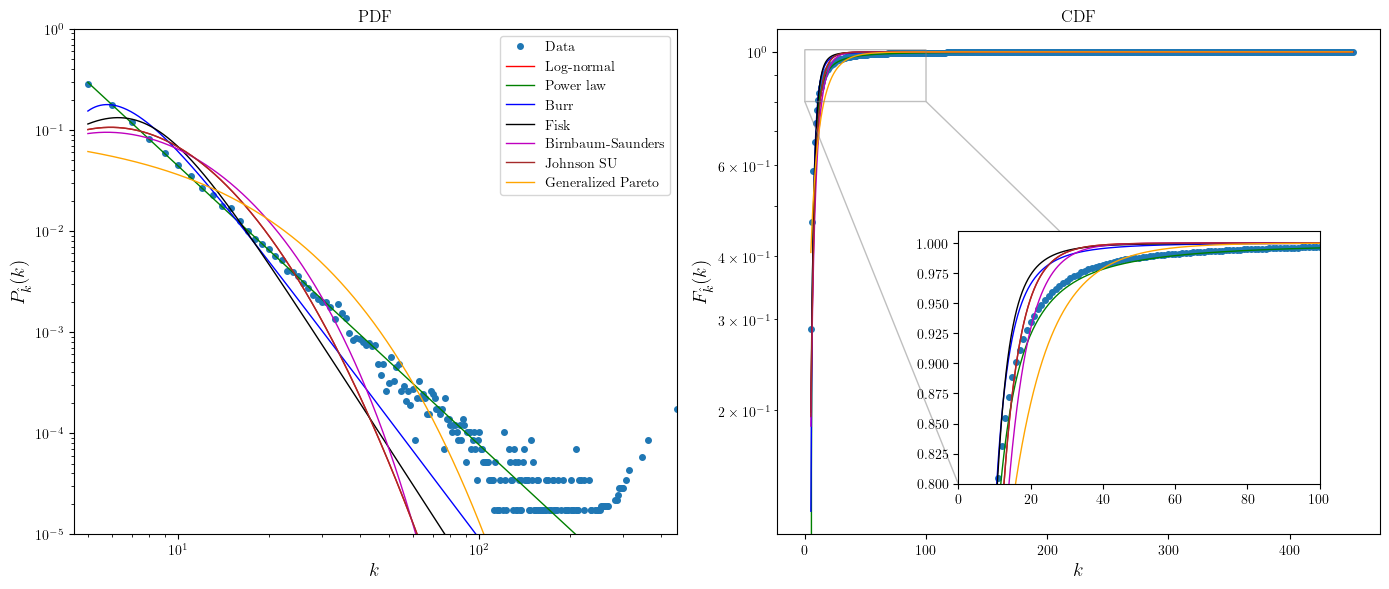

In [36]:
fitting_model(G, "Barabasi-Albert", N=10)

### Comparison between real and Barabasi-Albert network

In [53]:
def plot_average_pdf_model_vs_real(G, model, N=10):

    """Function to plot the average pdf and cdf of a model with their standard deviation and the real data"""

    avg_pdf, std_pdf, avg_cdf, std_cdf = average_pdf_model(G, model, N)
    p_k, degrees = prob_degree(G)
    cummul_p_k = cummul_degree_distribution(p_k)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    ax[0].plot(avg_pdf, label="Average PDF", color='k')
    ax[0].fill_between(np.arange(len(avg_pdf)), avg_pdf-std_pdf, avg_pdf+std_pdf, alpha=0.3, label="Standard deviation", color='k')
    ax[0].plot(degrees, p_k, '.', label="Data", markersize=8)
    ax[0].set_xlabel(r"$k$", fontsize=14)
    ax[0].set_ylabel(r"$P_{\hat{k}}(k)$", fontsize=14)
    ax[0].legend()
    ax[0].set_title("PDF")

    if model == "Barabasi-Albert":
        fig.suptitle("Barabási-Albert model", fontsize=16)
        ax[0].set_xscale("log")
        ax[0].set_yscale("log")
        ax[0].set_ylim(1e-6, 1)


    ax[1].plot(avg_cdf, label="Average CDF", color='k')
    ax[1].fill_between(np.arange(len(avg_cdf)), avg_cdf-std_cdf, avg_cdf+std_cdf, alpha=0.3, label="Standard deviation", color='k')
    ax[1].plot(degrees, cummul_p_k, '.', label="Data", markersize=8)
    ax[1].set_title("CDF")
    ax[1].set_xlabel(r"$k$", fontsize=14)
    ax[1].set_ylabel(r"$F_{\hat{k}}(k)$", fontsize=14)
    # ax[1].set_ylim(0.9, 1)
    ax[1].set_xlim(np.min(degrees), np.max(degrees))

    plt.tight_layout()
    plt.show()

    return

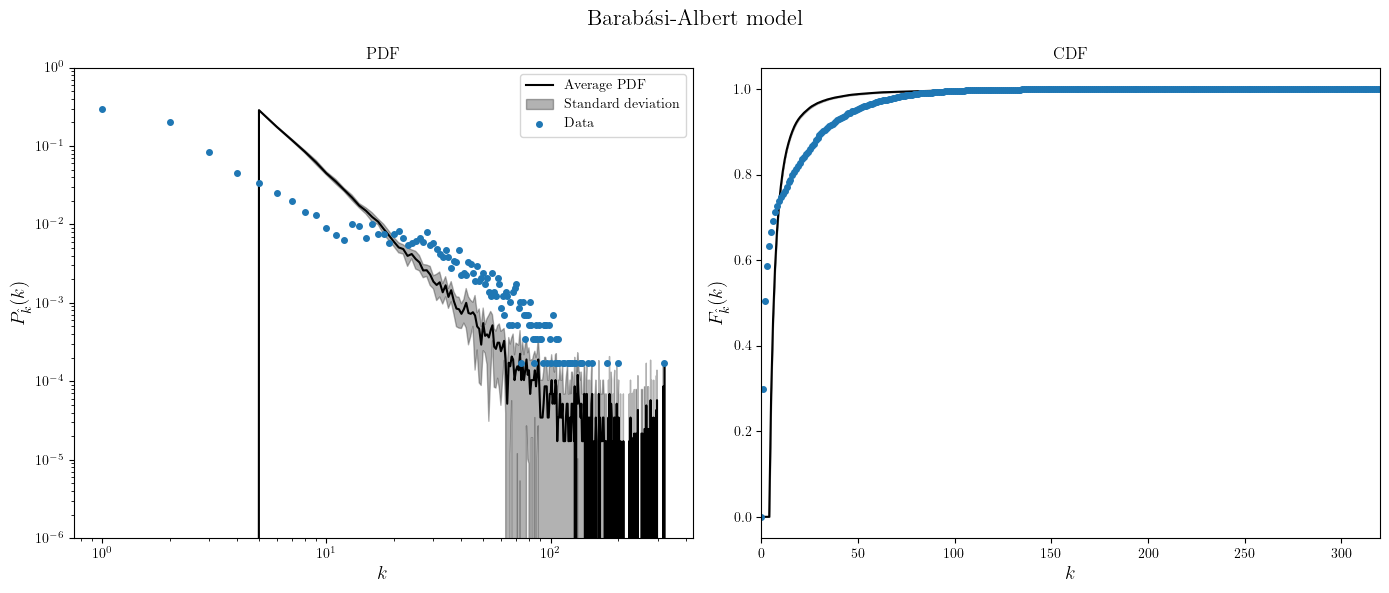

In [55]:
plot_average_pdf_model_vs_real(G, "Barabasi-Albert", N=10)

## Community detection

### Simple graph visualization

In [39]:
def graph_visualization(G):
    
    """Function to visualize the graph"""
    
    plt.figure(figsize=(14, 10))
    pos = nx.kamada_kawai_layout(G)
    node_degrees = np.array([val for (node, val) in G.degree()])
    node_betweenness = np.array([val for (node, val) in nx.betweenness_centrality(G).items()])
    nx.draw(G, pos,
            node_size=50*np.sqrt(node_degrees),
            node_color=node_betweenness,
            cmap='plasma',
            edge_color='gray',
            with_labels=False)
    plt.show()
    
    return

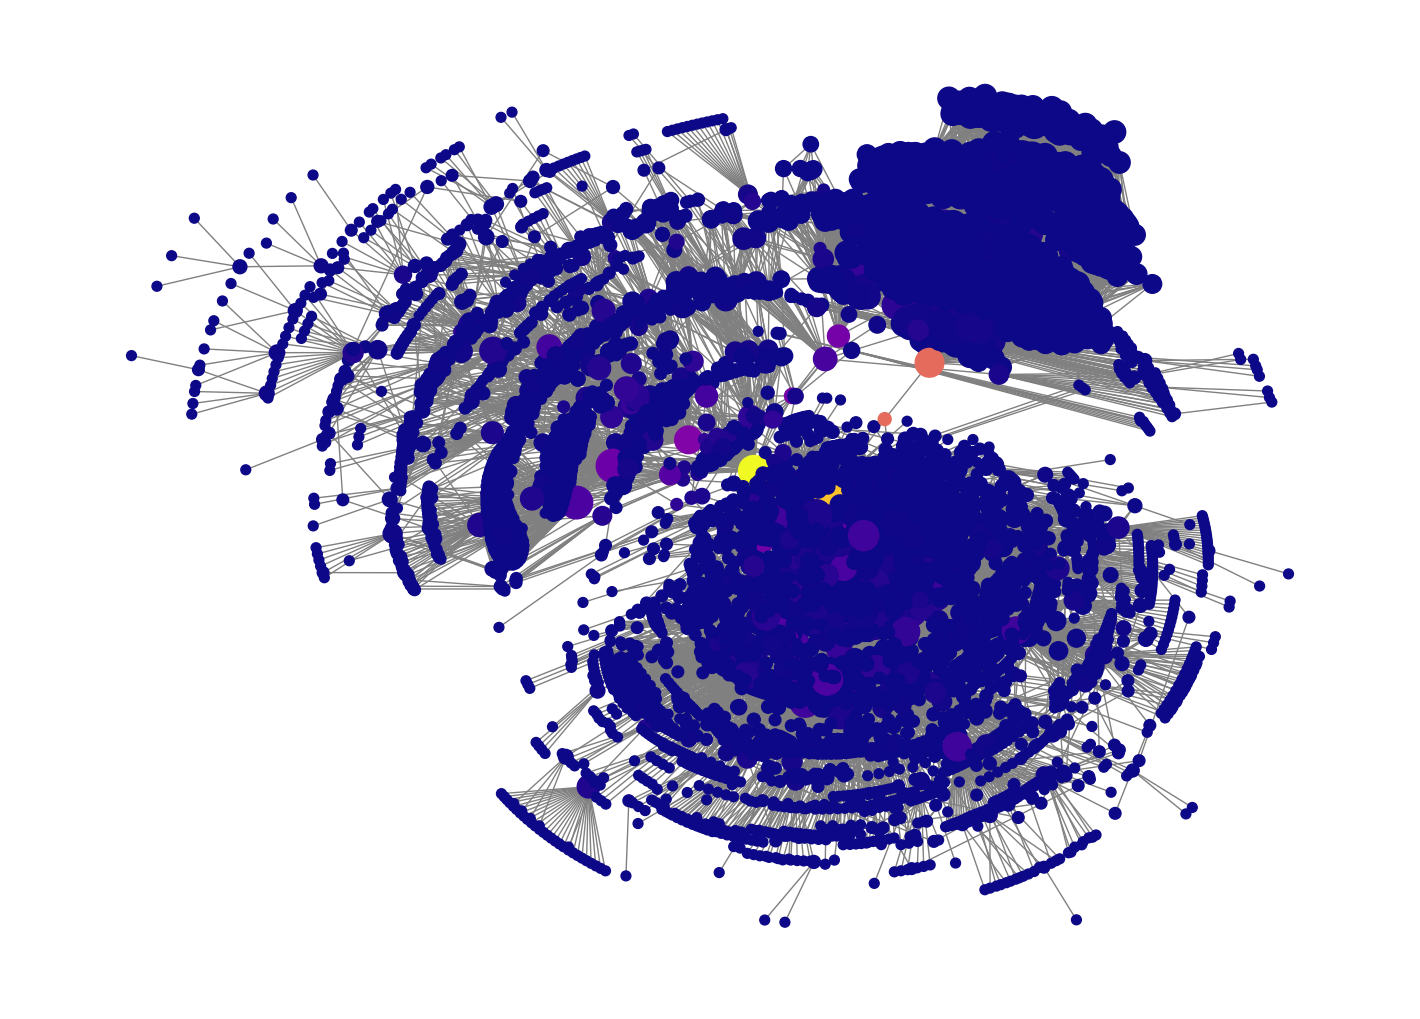

In [40]:
graph_visualization(G)

### Communities

In [41]:
# from community import community_louvain

In [42]:
def community_detection(G, method, resolution=1):

    """Function to detect communities in a graph by applying different algorithms"""
    
    if method == "Girvan-Newman":
        communities = nx.community.girvan_newman(G)
    elif method == "Louvain":
        # communities = community_louvain.best_partition(G, resolution=resolution)
        communities = nx.community.louvain_communities(G, resolution=resolution)
    elif method == "Greedy":
        communities = nx.community.greedy_modularity_communities(G)
    else:
        raise ValueError("Invalid method: choose between Girvan-Newman, Louvain or Greedy")
    
    return communities

### Quality of partitions

In [43]:
def community_quality(G, method, N=1, resolution=1):
    
    """Function to evaluate the quality of the communities detected"""

    n_com = []
    modularity = []
    coverage = []
    performance = []
        
    for i in range(N):

        print(f"Iteration {i+1}")
        
        communities = community_detection(G, method, resolution=resolution)

        # if method == "Louvain":
            
        #     # Convert the dictionary to a list of sets
        #     partition = {}
        #     for node, com in communities.items():
        #         partition.setdefault(com, set()).add(node)
        #     communities = list(partition.values())

        modularity = nx.community.quality.modularity(G, communities)
        partition_quality = nx.community.partition_quality(G, communities)
        coverage.append(partition_quality[0])
        performance.append(partition_quality[1])
        n_com.append(len(communities))
        
    quality = {
        "Communities": np.mean(n_com),
        "Modularity": np.mean(modularity),
        "Coverage": np.mean(coverage),
        "Performance": np.mean(performance),
        }
    
    error = {
        "Communities": np.std(n_com)/np.sqrt(N),
        "Modularity": np.std(modularity)/np.sqrt(N),
        "Coverage": np.std(coverage)/np.sqrt(N),
        "Performance": np.std(performance)/np.sqrt(N),
    }
        
    return quality, error

In [44]:
community_quality(G, "Louvain", N=100, resolution=1)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

({'Communities': np.float64(20.38),
  'Modularity': np.float64(0.7573990725674079),
  'Coverage': np.float64(0.906214027899717),
  'Performance': np.float64(0.8639400297844702)},
 {'Communities': np.float64(0.17133592734741887),
  'Modularity': np.float64(0.0),
  'Coverage': np.float64(0.0005064446072959034),
  'Performance': np.float64(0.001138217774063676)})

In [45]:
community_quality(G, "Louvain", N=100, resolution=0.8)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

({'Communities': np.float64(18.28),
  'Modularity': np.float64(0.7564435802513861),
  'Coverage': np.float64(0.9191386206223782),
  'Performance': np.float64(0.8313124944565409)},
 {'Communities': np.float64(0.1543243337908834),
  'Modularity': np.float64(0.0),
  'Coverage': np.float64(0.00039120198641308867),
  'Performance': np.float64(0.0011006228752059653)})

In [46]:
community_quality(G, "Louvain", N=10, resolution=0.5)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


({'Communities': np.float64(11.6),
  'Modularity': np.float64(0.723873270002591),
  'Coverage': np.float64(0.9403667934835627),
  'Performance': np.float64(0.780208670113387)},
 {'Communities': np.float64(0.5692099788303082),
  'Modularity': np.float64(0.0),
  'Coverage': np.float64(0.0011780767451445367),
  'Performance': np.float64(0.009382285389684147)})

In [47]:
community_quality(G, "Louvain", N=10, resolution=0.2)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


({'Communities': np.float64(6.7),
  'Modularity': np.float64(0.646888980539192),
  'Coverage': np.float64(0.9818489253081001),
  'Performance': np.float64(0.6055718978324955)},
 {'Communities': np.float64(0.20248456731316586),
  'Modularity': np.float64(0.0),
  'Coverage': np.float64(0.0018374568094729935),
  'Performance': np.float64(0.0012750373067426833)})

In [48]:
community_quality(G, "Greedy", N=1)

Iteration 1


({'Communities': np.float64(27.0),
  'Modularity': np.float64(0.6717614430224437),
  'Coverage': np.float64(0.9512242708028485),
  'Performance': np.float64(0.7452317905111236)},
 {'Communities': np.float64(0.0),
  'Modularity': np.float64(0.0),
  'Coverage': np.float64(0.0),
  'Performance': np.float64(0.0)})

In [49]:
# # Not recommendable for this graph, extremely slow
# community_quality(G, "Girvan-Newman", N=1)

Community visualization https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx

In [50]:
def louvain_as_dict(communities):
    
    """Function to convert the Louvain communities to a dictionary"""
    
    partition = {}
    for i, com in enumerate(communities):
        for node in com:
            partition[node] = i
            
    return partition

In [51]:
# Define custom spring layout forces
def custom_spring_layout(G, partition, same_community_weight=100, different_community_weight=1):
    pos = nx.kamada_kawai_layout(
        G,
        weight=None,  # We will use our custom weights
    )
    # Adjust forces based on community
    for (u, v) in G.edges():
        if partition[u] == partition[v]:
            G[u][v]["weight"] = same_community_weight
        else:
            G[u][v]["weight"] = different_community_weight
    return pos

def community_visualization(G, method, resolution=1):

    """Function to visualize the communities in a graph"""

    # Detect communities using Louvain method
    communities = community_detection(G, method, resolution=resolution)
    partition = louvain_as_dict(communities)
    print(partition)
    print(partition[3])

    if method == "Louvain":
        communities = set(partition.values())
    else:
        communities = partition

    # Assign colors to communities
    print(f"Number of communities: {len(communities)}")
    # assign 23 colors to the communities
    community_to_color = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: '#FF00FF',  # magenta
    11: '#808000',  # olive
    12: '#00008B',  # darkblue
    13: '#8B0000',  # darkred
    14: '#006400',  # darkgreen
    15: '#FFD700',  # darkyellow
    16: '#800080',  # darkpurple
    17: '#FF8C00',  # darkorange
    18: '#FF69B4',  # darkpink
    19: '#A9A9A9',  # darkgray
    20: '#00CED1',  # darkcyan
    21: '#8B008B',  # darkmagenta
    22: '#556B2F',  # darkolive
}

    node_colors = [community_to_color[partition[node]] for node in G.nodes()]
    print(node_colors[3])

    # node_colors = [colors[partition[node]] for node in G.nodes()]

    # Apply custom spring layout
    pos = custom_spring_layout(G, partition)

    # nodedeg
    node_deg = dict(G.degree)
    node_sizes = [node_deg[node] * 10 for node in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(14, 12))
    
    # Draw nodes with different shapes separately
    for shape in ['o', 's', '^']:
        nodes = [node for node in G.nodes() if ('o' if partition[node] < 8 else 's' if partition[node] < 16 else '^') == shape]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[community_to_color[partition[node]] for node in nodes], node_size=[np.sqrt(node_deg[node]) * 10 for node in nodes], alpha=1, edgecolors='k', linewidths=0.5, node_shape=shape)
    
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    # plt.title("Graph with Community-Based Layout")
    plt.show()

    return



{4105: 0, 4106: 0, 4107: 0, 4108: 0, 4109: 0, 4110: 0, 4111: 0, 4112: 0, 4113: 0, 3090: 0, 3091: 0, 4114: 0, 4115: 0, 4116: 0, 4117: 0, 4120: 0, 4118: 0, 4119: 0, 4121: 0, 4122: 0, 4123: 0, 5150: 0, 5151: 0, 5152: 0, 4124: 0, 4125: 0, 4126: 0, 4127: 0, 4128: 0, 4152: 0, 78: 0, 79: 0, 5221: 0, 5222: 0, 5223: 0, 2154: 0, 2155: 0, 2165: 0, 2166: 0, 5245: 0, 126: 0, 127: 0, 5523: 0, 5524: 0, 5525: 0, 2199: 0, 2200: 0, 1210: 0, 1211: 0, 1212: 0, 5315: 0, 5316: 0, 5317: 0, 5318: 0, 5319: 0, 5320: 0, 5321: 0, 5534: 0, 3276: 0, 5328: 0, 4726: 0, 1254: 0, 4727: 0, 1255: 0, 1256: 0, 4728: 0, 5371: 0, 2300: 0, 3339: 0, 3340: 0, 4735: 0, 4390: 0, 5450: 0, 5451: 0, 3410: 0, 2420: 0, 2421: 0, 2422: 0, 5501: 0, 5502: 0, 5503: 0, 5504: 0, 5505: 0, 5506: 0, 5507: 0, 5508: 0, 5776: 0, 5509: 0, 5510: 0, 5511: 0, 5512: 0, 5777: 0, 5513: 0, 5516: 0, 5514: 0, 5515: 0, 5519: 0, 5520: 0, 5778: 0, 5517: 0, 5518: 0, 5779: 0, 5521: 0, 5522: 0, 5527: 0, 408: 0, 5529: 0, 5530: 0, 5531: 0, 5532: 0, 5533: 0, 409: 0,

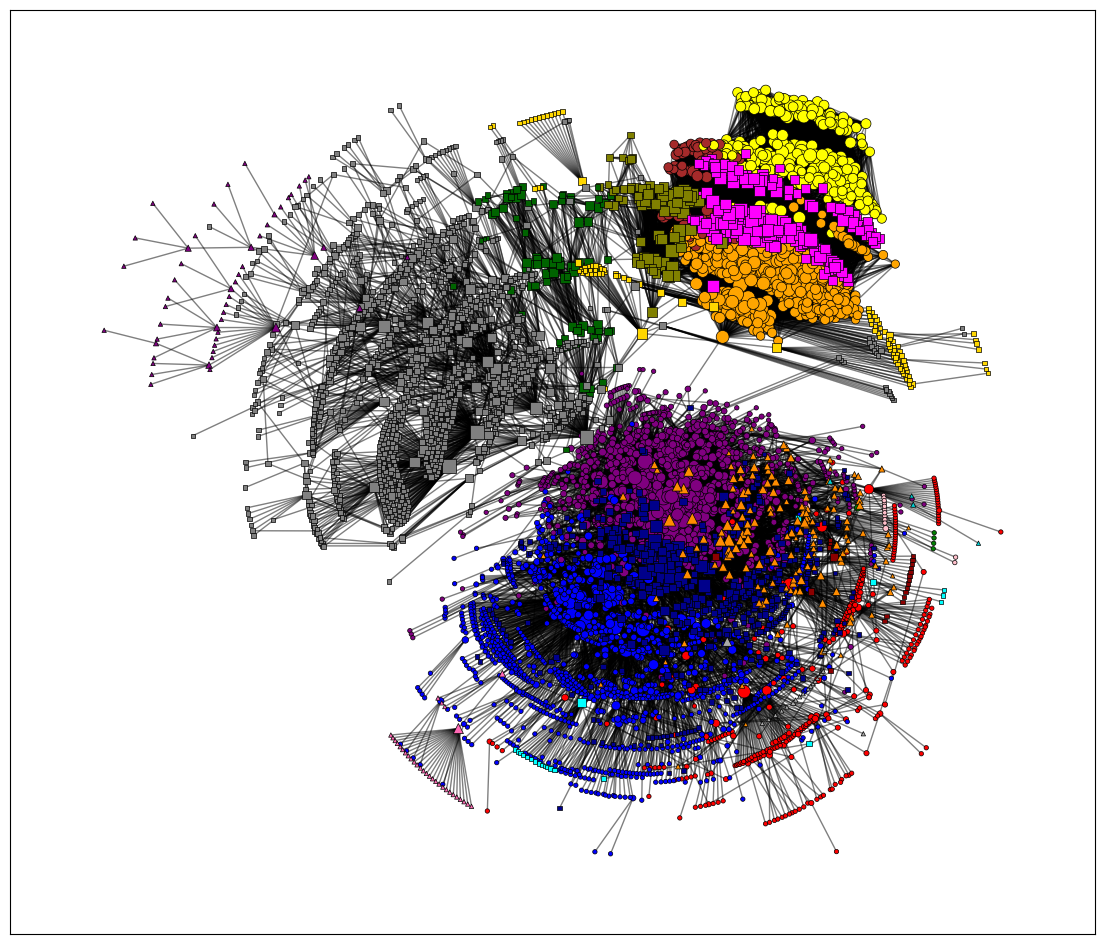

In [56]:
community_visualization(G, "Louvain", resolution=1)